In [2]:
%load_ext autoreload
%autoreload 2


In [1]:
import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
    
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import csv
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy import stats

import warnings
warnings.filterwarnings("ignore")
from src.constants import CLEANED_HOUSEHOLD_POWER_PATH, CLEANED_WEATHER_PATH, \
    HOUSEHOLD_WEATHER_MERGED_PATH

## Hourly distribution

In [3]:
df = pd.read_pickle(
    HOUSEHOLD_WEATHER_MERGED_PATH    
)

house_consumpion_columns = [
    'global_active_power', 
    'global_reactive_power', 
    'voltage',
    'global_intensity', 
    'sub_metering_1', 
    'sub_metering_2',
    'sub_metering_3'
]

df.head()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,numer_sta,pmer,tend,...,phenspe1,phenspe2,phenspe3,nnuage1,ctype1,hnuage1,Nom,Latitude,Longitude,Altitude
date,,,,,,,,,,,,,,,,,,,,,
2007-01-01 00:00:00,2.580,0.136,241.97,10.6,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:01:00,2.552,0.100,241.75,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:02:00,2.550,0.100,241.64,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:03:00,2.550,0.100,241.71,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:04:00,2.554,0.100,241.98,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0


In [4]:
consumption_df = df[house_consumpion_columns]
consumption_df.head()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
date,,,,,,,
2007-01-01 00:00:00,2.580,0.136,241.97,10.6,0.0,0.0,0.0
2007-01-01 00:01:00,2.552,0.100,241.75,10.4,0.0,0.0,0.0
2007-01-01 00:02:00,2.550,0.100,241.64,10.4,0.0,0.0,0.0
2007-01-01 00:03:00,2.550,0.100,241.71,10.4,0.0,0.0,0.0
2007-01-01 00:04:00,2.554,0.100,241.98,10.4,0.0,0.0,0.0


### Normality test

In [71]:
test_results = consumption_df['global_active_power']\
    .groupby(pd.Grouper(freq="1H"))\
    .apply(
        lambda x : np.nan if len(x) == 0 else stats.kstest(x, stats.norm.cdf)
    )

In [72]:
test_results_df = test_results.apply(
    lambda x: (np.nan, np.nan) if np.isnan(x).any() else (x.statistic, x.pvalue)
)

test_results_df = pd.DataFrame(
    test_results_df.to_list(), 
    columns = ['statistic', 'pvalue'],
    index = test_results.index    
)

In [99]:
test_results_df.dropna()

,statistic,pvalue
date,,
2007-01-01 00:00:00,0.992975,1.254702e-129
2007-01-01 01:00:00,0.992737,9.267528e-129
2007-01-01 02:00:00,0.993755,1.076918e-132
2007-01-01 03:00:00,0.991892,6.872219e-126
2007-01-01 04:00:00,0.991622,4.906382e-125
...,...,...
2010-12-11 19:00:00,0.944756,6.891668e-76
2010-12-11 20:00:00,0.751114,1.481435e-35
2010-12-11 21:00:00,0.621720,6.633837e-23


In [101]:
test_results_df.pvalue.max(), test_results_df.pvalue.argmax()

(0.010842012774716431, 34221)

In [89]:
(test_results_df.pvalue > 5e-2).sum()

0

In [108]:
iterator = iter(consumption_df.groupby(pd.Grouper(freq="1H")))

<Figure size 1000x600 with 0 Axes>

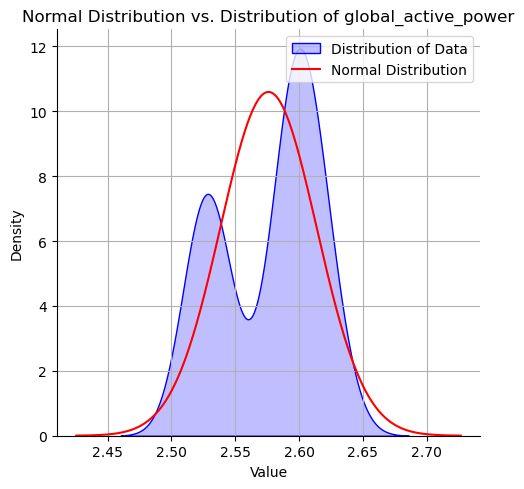

In [ ]:

from scipy.stats import norm

df1 = next(iterator)[1]

column = 'global_active_power'
series = df1[column]

# Calculate the mean and standard deviation
mean = series.mean()
std = series.std()

# Create a range of values for plotting the theoretical normal distribution
x = np.linspace(mean - 4*std, mean + 4*std, 1000)
y = norm.pdf(x, mean, std)  # PDF of the normal distribution

# Start plotting
plt.figure(figsize=(10, 6))
sns.displot(series, color="blue", label="Distribution of Data", fill=True, kind = 'kde')

# Plot the normal distribution
plt.plot(x, y, color="red", label="Normal Distribution")

# Plot details
plt.title(f'Normal Distribution vs. Distribution of {column}')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("img/normality_test.png")
plt.show()

## Comparing between hours in a day

In [127]:
batches = consumption_df['global_active_power'].groupby(
    pd.Grouper(freq = '1H')
)\
    .mean()\
    .groupby(
        pd.Grouper(freq = '1D')
    )

In [130]:
iterator = iter(batches)

Text(0.5, 1.0, 'Hourly consumption on a day- Saturday, 20/01/2007')

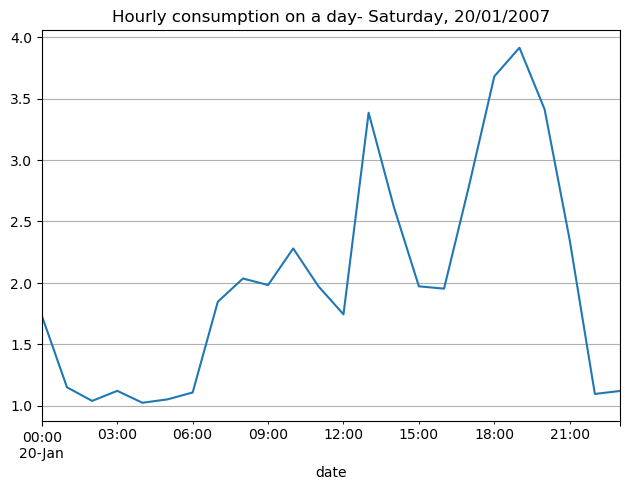

In [161]:
daily_data =next(iterator) 

day_of_the_week = daily_data[0].strftime("%A") 
data_str = daily_data[0].strftime("%d/%m/%Y") 

daily_data[1].plot()
plt.grid()
plt.tight_layout()
plt.title(f"Hourly consumption on a day- {day_of_the_week}, {data_str}")